In [147]:
import pandas as pd
import numpy as np
#import pymc as pm
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D 
from scipy.optimize import fmin_tnc
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline 

In [148]:
def load_data(file):
    info = {
        'AusCredit.csv':['X5','X8','Y'],
        'BreastCancer.csv':['X1','X6','Y'],
        'Diabetes.csv':['X2','X6','Y'],
        'heart.csv':['X3','X12','Y']
    }
    dat = pd.read_csv(file)
    dat = dat[info[file]]
    dat.columns = ['X1','X2','Y']
    
    X,y = dat.drop(columns = ['Y']),dat['Y']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )
    
    X_train, X_test, y_train, y_test = X_train.reset_index(drop = True),X_test.reset_index(drop = True),y_train.reset_index(drop = True),y_test.reset_index(drop = True)
    
    return [X_train, X_test, y_train, y_test]

In [149]:
def ROC(y_score, y_test,title):
    y_score,y_test = np.array(y_score),np.array(y_test)
    enc = OneHotEncoder(categories='auto')
    y_score,y_test = enc.fit_transform(y_score.reshape(-1,1)).toarray(),enc.fit_transform(y_test.reshape(-1,1)).toarray()
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

    #f, ax = plt.subplots(figsize=(8, 8))
    #plt.subplot(n)
    
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

### Executive Summary
<br />
We are trying 3 approaches of Logistic regression 1) Using MCMC sampling for parameters. 2) Using Gradient Descent and 3) SK-Learn library. We have four very generic datasets that we will use to test out all the algorithms. For the purpose of visualization and reduced computational complexity, for each data set we have selected the two most significant variables to be used as influential attributes. We will test the perfromances using a ROC curve and a test set which has 30% of the data. 

In [150]:
dbts = load_data("Diabetes.csv")
x1_d,x2_d = dbts[0]['X1'],dbts[0]['X2']
cls = list(dbts[2])

## Logistic Regression with MCMC parameter sampling

### Applying some changes to normal distribution

We have traditionally used the normal distribution as follows $N\text{~}(\mu, \sigma^2)$ <br />
Substituting variance($\sigma^2$) with precision($\tau$) which has inverse relation gives us $N\text{~}(\mu, \tau^{-1})$ <br />
Constraints $\tau$ is always positive <br />
<br />
Traditional normal distribution function<br/>
<br />
$$f(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$
Altered function with precision<br/>
<br />
$$f(x|\mu,\tau^{-1}) = \frac{1}{\sqrt{2\pi\tau^{-1}}}e^{-\frac{(x-\mu)^2}{2\tau^{-1}}}$$
$$f(x|\mu,\tau^{-1}) = \frac{1}{\sqrt{2\pi \frac{1}{\tau}}}e^{-\frac{(x-\mu)^2}{2\frac{1}{\tau}}}$$
$$f(x|\mu,\tau) = \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}{(x-\mu)^2}}$$
<br />
<br />
### Model
<br />
<br />
$$p(Y_i) = \frac{1}{1+e^{\beta_1 X_1+ \beta_2 X_2+ \alpha}}$$
<br />
<br />
$$\text{Where }\beta_1\text{~}N(\mu = 0, \tau = 0.001)$$
<br />
<br />
$$\text{Where }\beta_2\text{~}N(\mu = 0, \tau = 0.001)$$
<br />
<br />
$$\text{Where }\alpha\text{~}N(\mu = 0, \tau = 0.001)$$


In [151]:
class bin_model():
    def __init__(self):
        self.name = 'logmodel'
        self.beta_1_samples = None
        self.beta_2_samples = None
        self.alpha_samples = None
        self.forge = None
        
    def logistic(self,x, beta, alpha=0):
        return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))
    
    
    def forge(self):
        data = {}
        samples =  [self.beta_1_samples,self.beta_2_samples]
        for i,v in enumerate(samples):
            data['x'+str(i)] = np.ndarray.flatten(v)
        return pd.DataFrame(data).values
        
    def fit(self,x_val_1,x_val_2,y_val,ch_c=1):
        with pm.Model() as model1:
            
            beta1 = pm.Normal("beta1", mu=0, tau=0.001, testval=0)
            beta2 = pm.Normal("beta2", mu=0, tau=0.001, testval=0)

            alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
            p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta1*x_val_1 + beta2*x_val_2 + alpha)))
            
            observed = pm.Bernoulli("bernoulli_obs", p, observed=y_val)
            
            start = pm.find_MAP()
            step = pm.Metropolis()
            trace = pm.sample(10000, step=step, start=start,chains = ch_c)
            burned_trace = trace[2000:]
        
        self.beta_1_samples = burned_trace["beta1"][2000:]
        self.beta_2_samples = burned_trace["beta2"][2000:]
        self.alpha_samples = burned_trace["alpha"][2000:]
        
        self.forge = self.forge_d()
            
    
    def forge_d(self):
        data = {}
        samples =  [self.beta_1_samples,self.beta_2_samples]
        for i,v in enumerate(samples):
            data['x'+str(i)] = np.ndarray.flatten(v)
        return pd.DataFrame(data).values
    
    def predict(self,X):
        answers= []
        for i in X:
            answers.append(round(np.median(self.logistic(x =i,beta = self.forge,alpha = self.alpha_samples))))
        return answers
    
    def predict_proba(self,X):
        answers= []
        for i in X:
            answers.append(np.median(self.logistic(x =i,beta = self.forge,alpha = self.alpha_samples)))
        return answers
    
    def retrieve_dat(self):
        return [
        self.beta_1_samples,
        self.beta_2_samples,
        self.alpha_samples,
            
        ]
    
    def sketch_fit(self,xmin1 = 0,xmax1 = 100,xmin2 = 0,xmax2 = 100, a = 1, b = 1, Add_scatter = False,
                  x=None,y=None,z=None):
        X1 = np.arange(xmin1,xmax1,a)
        X2 = np.arange(xmin2,xmax2,b)
        X_surf1,X_surf2 = np.meshgrid(X1,X2)
        
        dxt = []
        for i in range(len(X_surf1)):
            set1,set2 = X_surf1[i],X_surf2[i]
            rec1 = []
            for j in range(len(set1)):
                data = [[set1[j],set2[j]]]
                output = self.predict_proba(data)
                rec1.append(output[0])
            dxt.append(np.array(rec1))
            
        fig = plt.figure(figsize=(20, 10))
        
        ax = fig.add_subplot(111, projection='3d')

        #ax.scatter(dbts[0]['X1'],dbts[0]['X2'],dbts[2], c = 'red', s =10)
        ax.plot_surface(X_surf1,X_surf2,np.array(dxt),rstride = 10, cstride = 10, color='red', alpha=0.05)
        ax.plot_wireframe(X_surf1,X_surf2,np.array(dxt),rstride = 10, cstride = 10)


        ax.set_xlim([0,200])
        ax.set_ylim([0,100])
        ax.set_zlim([0,1])

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label') 
        if Add_scatter == True:
            ax.scatter(x,y,z, c = 'red', s =10)

In [152]:
clf = bin_model()
clf.fit(x1_d,x2_d,cls,ch_c=4)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -273.25, ||grad|| = 4.7659: 100%|██████████| 36/36 [00:00<00:00, 2048.50it/s]   
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta2]
>Metropolis: [beta1]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3769.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


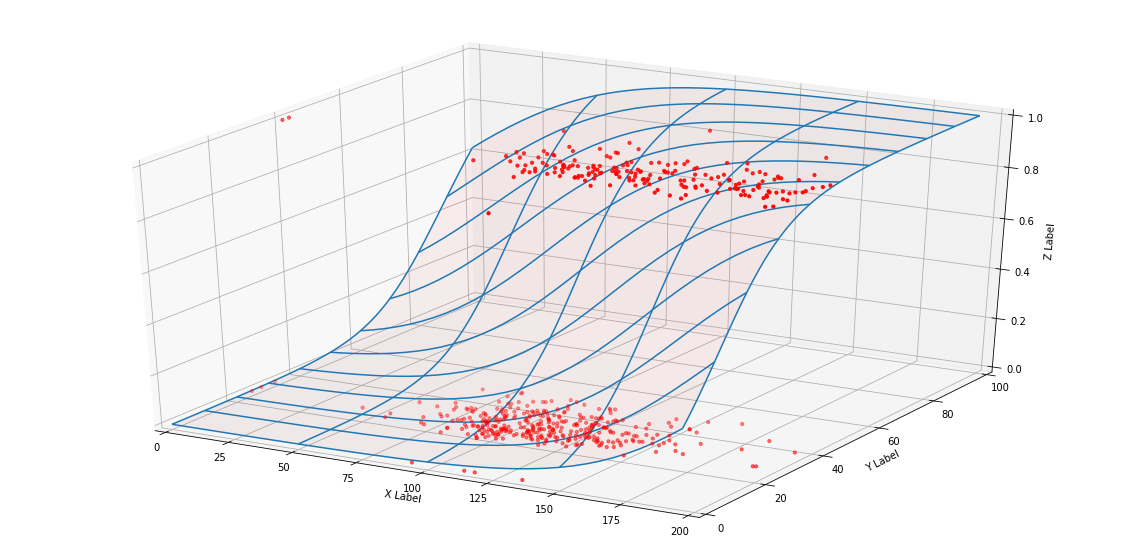

In [153]:
clf.sketch_fit(0,200,0,100,5,Add_scatter = True,x=dbts[0]['X1'],y=dbts[0]['X2'],z=dbts[2])

<b>Figure 1: Logistic Regression plane/surface</b>
<br />
Above shows the fit of the model, the main area of interest is not the coverage but rather curvature in elevation which indicates the quality of fit of the data.

In [154]:
beta1_samples,beta2_samples,alpha_samples = clf.retrieve_dat()



 Median values for beta_1 = -0.03889212031965092, beta_2 = -0.09156391902216159, alpha = 8.514281826155802 




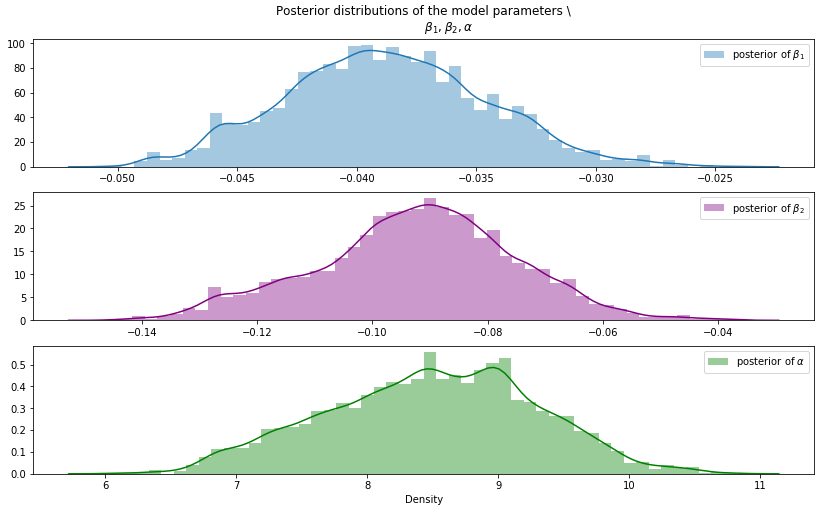

In [155]:
f, ax = plt.subplots(figsize=(14, 8))

plt.subplot(311)
plt.title(r"Posterior distributions of the model parameters \
             $\beta_1,\beta_2,\alpha$")

sns.distplot(beta1_samples,
            label=r"posterior of $\beta_1$")
plt.legend()

plt.subplot(312)


sns.distplot(beta2_samples,
            label=r"posterior of $\beta_2$", color = 'purple')
plt.legend()

plt.subplot(313)

sns.distplot(alpha_samples,
            label=r"posterior of $\alpha$", color = 'green')
plt.xlabel("Value of parameter")
plt.xlabel("Density")
plt.legend()

print ("\n\n Median values for beta_1 = {}, beta_2 = {}, alpha = {} \n\n".format(
    np.median(beta1_samples),
    np.median(beta2_samples),
    np.median(alpha_samples)))

Based on our MCMC samples, the median's for the posteriers for our parameters are as follows.<br />
<br />
$$\beta_1 = -0.039$$
$$\beta_2 = -0.095$$
$$\alpha = 8.64$$
<br />
<br />
This algorithm uses medians of the posterier values as estimates for parameters.

## Logistic Regression Gradient Decent

We can define a linear regression model using the following relationship.<br />
<br />
<br />
$$h(x) = \theta^{T}x$$
<br />
<br />
To this function we can apply the sigmoid function to represent our case for logistic regression
<br />
<br />
$$h(x) = \sigma(\theta^{T}x)$$
<br />
<br />
Where
<br />
<br />
$$\sigma(v) = \frac{1}{1+e^{-v}}$$
<br />
<br />
Hence
<br />
<br />
$$h(x) = \frac{1}{1+e^{-\theta^{T}x}}$$
<br />
<br />
Decision Rule
<br />
<br />
$$h(x) =   
     \begin{cases}
       \text{> 0.5, if }\theta^{T}x{ >0}\\
       \text{< 0.5, if }\theta^{T}x{ <0}\\
     \end{cases}$$
<br />
<br />
<b>Cost Function</b>
$$Cost =   
     \begin{cases}
       \text{-log h(x), if  y = 1}\\
       \text{-log h(1 - h(x)), if y = 0}\\
     \end{cases}$$
<br />
<br />
<i>"If the actual class is 1 and the model predicts 0, we should highly penalize it and vice-versa. As you can see from the below picture, for the plot -log(h(x)) as h(x) approaches 1, the cost is 0 and as h(x) nears 0, the cost is infinity(that is we penalize the model heavily). Similarly for the plot -log(1-h(x)) when the actual value is 0 and the model predicts 0, the cost is 0 and the cost becomes infinity as h(x) approaches 1."</i> 
<br />
<br />
Animesh Aggrawal [https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24]
<br />
<br />
Combined Cost Function
<br />
$$cost(h(x),y) = -ylog(h(x)) - (1 - y)log(1 - h(x))$$
<br />
<br />
Cost for all training examples where m = Number of samples. Computed by taking the average over the cost of all the training samples
<br />
<br />
$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^i log(h(x^i)) + (1-y^i)log(1-h(x^i))]$$
<br />
<br />
Using gradient decent to minimize cost
<br />
<br />
$$\frac{\partial J(\theta)}{\partial \theta_j} = -\frac{1}{m}\sum_{i=1}^{m}(h(x^i) - y^i)x_j^i$$

In [156]:
class gd_model():
    """
    Inspired by Animesh Aggrawal.
    https://github.com/animesh-agarwal/Machine-Learning/blob/master/LogisticRegression/Model.py
    """
    def __init__(self):
        self.weight_vec = None
        self.b0_ = None
        self.b1 = None
        self.b2 = None
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def net_input(self,theta, x):
        return np.dot(x, theta)
    
    def probability(self, theta, x):
        return self.sigmoid(self.net_input(theta, x))

    def cost_function(self, theta, x, y):
        m = x.shape[0]
        total_cost = -(1 / m) * np.sum(
            y * np.log(self.probability(theta, x)) + (1 - y) * np.log(1 - self.probability(theta, x)))
        return total_cost
        
    def gradient(self, theta, x, y):
        m = x.shape[0]
        return (1 / m) * np.dot(x.T, self.sigmoid(self.net_input(theta, x)) - y)

    def fit(self, x, y):
        
        x = np.c_[np.ones((x.shape[0], 1)), x]
        y = y[:, np.newaxis]
        theta = np.zeros((x.shape[1], 1))
        
        opt_weights = fmin_tnc(func=self.cost_function, x0=theta, fprime=self.gradient,args=(x, y.flatten()))
        
        self.weight_vec = opt_weights[0]
        self.b0 = self.weight_vec[0]
        self.b1 = self.weight_vec[1]
        self.b2 = self.weight_vec[2]
    
    def predict(self,x): 
        out = []
        for x1,x2 in x.values:
            out.append(round(
                
                1 / (1 + np.exp(
                    -1*(
                        self.b0 + self.b1*x1 + self.b2*x2
                    )
                ))
            ))
        return out
    
    def predict_proba(self,x): 
        out = []
        for x1,x2 in x.values:
            out.append(
                
                1 / (1 + np.exp(
                    -1*(
                        self.b0 + self.b1*x1 + self.b2*x2
                    )
                ))
            )
        return out
    
    def _predict_proba(self,x): 
        out = []
        for x1,x2 in x:
            out.append(1 / (1 + np.exp(-1*(self.b0 + self.b1*x1 + self.b2*x2))))
        return out
    
    def sketch_fit(self,xmin1 = 0,xmax1 = 100,xmin2 = 0,xmax2 = 100, a = 1, b = 1, Add_scatter = False,
                  x=None,y=None,z=None):
        X1 = np.arange(xmin1,xmax1,a)
        X2 = np.arange(xmin2,xmax2,b)
        X_surf1,X_surf2 = np.meshgrid(X1,X2)
        
        dxt = []
        for i in range(len(X_surf1)):
            set1,set2 = X_surf1[i],X_surf2[i]
            rec1 = []
            for j in range(len(set1)):
                data = [[set1[j],set2[j]]]
                output = self._predict_proba(data)
                rec1.append(output[0])
            dxt.append(np.array(rec1))
            
        fig = plt.figure(figsize=(20, 10))
        
        ax = fig.add_subplot(111, projection='3d')

        #ax.scatter(dbts[0]['X1'],dbts[0]['X2'],dbts[2], c = 'red', s =10)
        ax.plot_surface(X_surf1,X_surf2,np.array(dxt),rstride = 10, cstride = 10, color='red', alpha=0.05)
        ax.plot_wireframe(X_surf1,X_surf2,np.array(dxt),rstride = 10, cstride = 10)


        ax.set_xlim([0,200])
        ax.set_ylim([0,100])
        ax.set_zlim([0,1])

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label') 
        if Add_scatter == True:
            ax.scatter(x,y,z, c = 'red', s =10)      
            
    def params(self):
        print ("""The paramter estimates for model are B0 = {}, B1 = {} B2 = {}""".format(self.b0,self.b1,self.b2))

In [157]:
clf2 = gd_model()
clf2.fit(dbts[0],dbts[2])

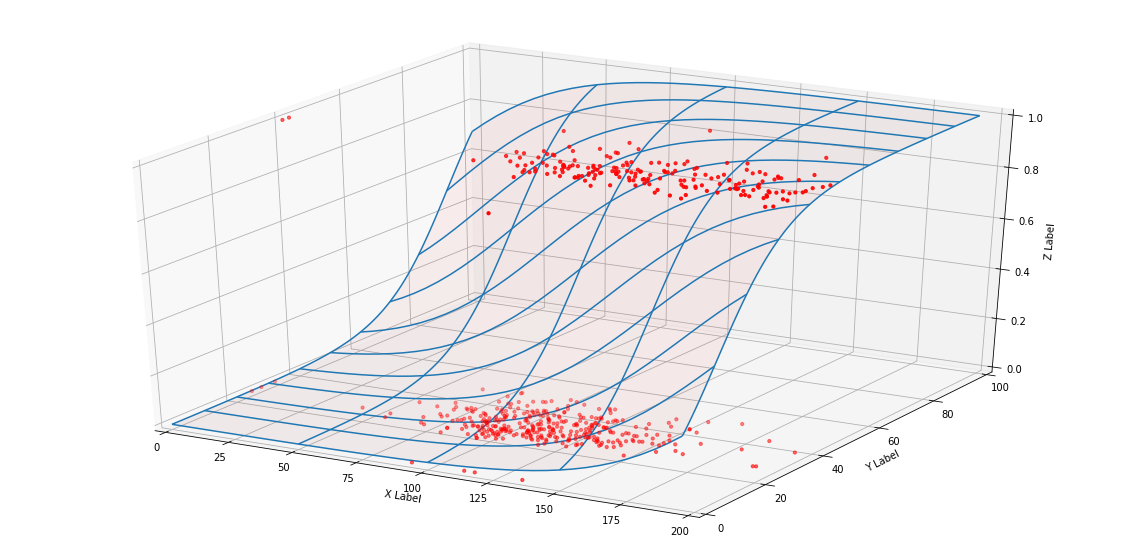

In [158]:
clf2.sketch_fit(0,200,0,100,5,Add_scatter = True,x=dbts[0]['X1'],y=dbts[0]['X2'],z=dbts[2])

<b>Figure 2: Logistic Regression plane/surface</b>
<br />
Above shows the fit of the model, the main area of interest is not the coverage but rather curvature in elevation which indicates the quality of fit of the data.

In [159]:
clf2.params()

The paramter estimates for model are B0 = -8.377851926252719, B1 = 0.0378956789260315 B2 = 0.09263150021627221


The parameters produced by the Gradient decent method.<br />
<br />
$$\beta_0 = -8.377$$
$$\beta_1 = 0.037$$
$$\beta_2 = 0.092$$
<br />
<br />
The results are similar to the MCMC method, but the signs(-/+) have inverted.
<br />
<br />
<h1>Model Comparisons<h1/>
    
<h2>Diabetes Dataset<h2/>

In [160]:
from sklearn.linear_model import LogisticRegression
sk_clf = LogisticRegression(random_state=0,multi_class='ovr').fit(dbts[0],dbts[2])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [161]:
from sklearn.metrics import accuracy_score
print ("The MCMC Model ",accuracy_score(clf.predict(dbts[1].values),dbts[3]))
print ("The Gradient Decent Model ",accuracy_score(clf2.predict(dbts[1]),dbts[3]))
print ("Sk-Learn Model", accuracy_score(sk_clf.predict(dbts[1]),dbts[3]))

The MCMC Model  0.7445887445887446
The Gradient Decent Model  0.7445887445887446
Sk-Learn Model 0.7489177489177489


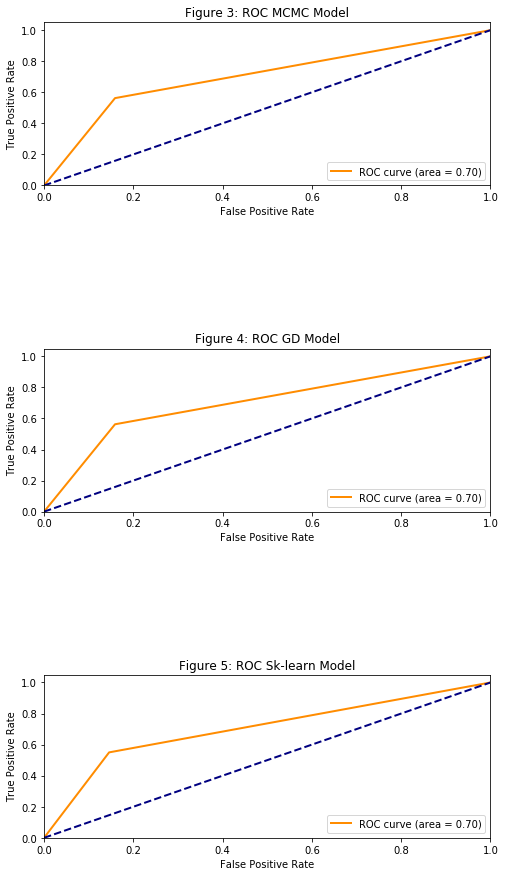

In [162]:
f, ax = plt.subplots(figsize=(8, 15))
plt.subplot(311)
ROC(clf.predict(dbts[1].values),dbts[3],"Figure 3: ROC MCMC Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(312)
ROC(clf2.predict(dbts[1]),dbts[3],"Figure 4: ROC GD Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(313)
ROC(sk_clf.predict(dbts[1]),dbts[3],"Figure 5: ROC Sk-learn Model")

## Breast Cancer Dataset

In [163]:
bc = load_data("BreastCancer.csv")
x1_b,x2_b = bc[0]['X1'],bc[0]['X2']
cls_bc = list(bc[2])

In [164]:
clf_bc = bin_model()
clf_bc.fit(x1_b,x2_b,cls_bc,ch_c=4)
clf2_bc = gd_model()
clf2_bc.fit(bc[0],bc[2])
sk_clf_bc = LogisticRegression(random_state=0,multi_class='ovr').fit(bc[0],bc[2])

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -91.501, ||grad|| = 14.072: 100%|██████████| 21/21 [00:00<00:00, 2082.52it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta2]
>Metropolis: [beta1]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3827.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [165]:
from sklearn.metrics import accuracy_score
print ("The MCMC Model ",accuracy_score(clf_bc.predict(bc[1].values),bc[3]))
print ("The Gradient Decent Model ",accuracy_score(clf2_bc.predict(bc[1]),bc[3]))
print ("Sk-Learn Model", accuracy_score(sk_clf_bc.predict(bc[1]),bc[3]))

The MCMC Model  0.9428571428571428
The Gradient Decent Model  0.9428571428571428
Sk-Learn Model 0.9476190476190476


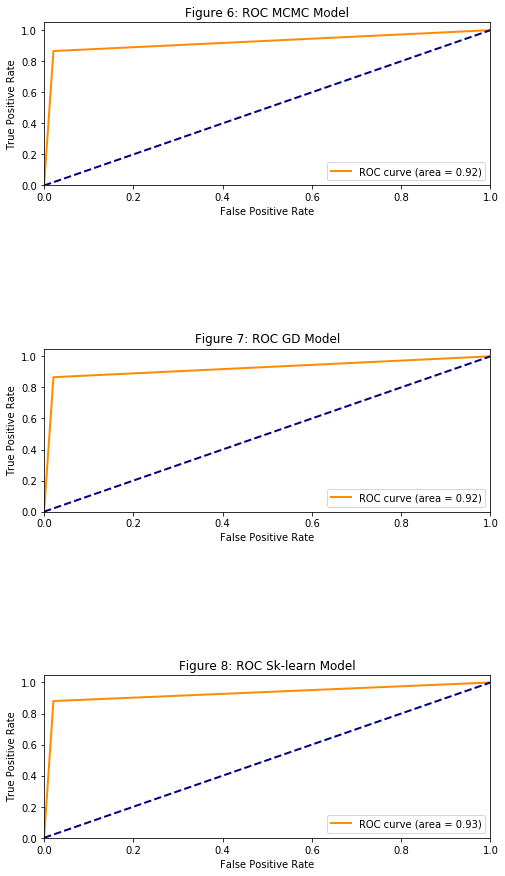

In [166]:
f, ax = plt.subplots(figsize=(8, 15))
plt.subplot(311)
ROC(clf_bc.predict(bc[1].values),bc[3],"Figure 6: ROC MCMC Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(312)
ROC(clf2_bc.predict(bc[1]),bc[3],"Figure 7: ROC GD Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(313)
ROC(sk_clf_bc.predict(bc[1]),bc[3],"Figure 8: ROC Sk-learn Model")

## Australian Credit Dataset

In [167]:
ac = load_data("AusCredit.csv")
x1_ac,x2_ac = ac[0]['X1'],ac[0]['X2']
cls_ac = list(ac[2])

In [168]:
clf_ac = bin_model()
clf_ac.fit(x1_ac,x2_ac,cls_ac,ch_c=4)
clf2_ac = gd_model()
clf2_ac.fit(ac[0],ac[2])
sk_clf_ac = LogisticRegression(random_state=0,multi_class='ovr').fit(ac[0],ac[2])

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -189.39, ||grad|| = 23.628: 100%|██████████| 26/26 [00:00<00:00, 1796.19it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta2]
>Metropolis: [beta1]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4039.91draws/s]
The number of effective samples is smaller than 10% for some parameters.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [169]:
print ("The MCMC Model ",accuracy_score(clf_ac.predict(ac[1].values),ac[3]))
print ("The Gradient Decent Model ",accuracy_score(clf2_ac.predict(ac[1]),ac[3]))
print ("Sk-Learn Model", accuracy_score(sk_clf_ac.predict(ac[1]),ac[3]))

The MCMC Model  0.8454106280193237
The Gradient Decent Model  0.8454106280193237
Sk-Learn Model 0.8502415458937198


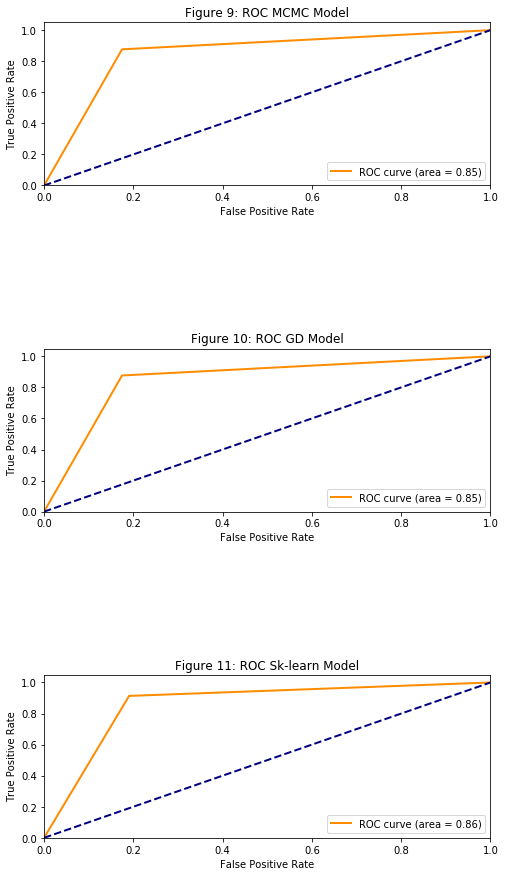

In [170]:
f, ax = plt.subplots(figsize=(8, 15))
plt.subplot(311)
ROC(clf_ac.predict(ac[1].values),ac[3],"Figure 9: ROC MCMC Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(312)
ROC(clf2_ac.predict(ac[1]),ac[3],"Figure 10: ROC GD Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(313)
ROC(sk_clf_ac.predict(ac[1]),ac[3],"Figure 11: ROC Sk-learn Model")

## Heart Attack Dataset

In [171]:
hc = load_data("heart.csv")
x1_hc,x2_hc = hc[0]['X1'],hc[0]['X2']
cls_hc = list(hc[2])

In [172]:
clf_hc = bin_model()
clf_hc.fit(x1_hc,x2_hc,cls_hc,ch_c=4)
clf2_hc = gd_model()
clf2_hc.fit(hc[0],hc[2])
sk_clf_hc = LogisticRegression(random_state=0,multi_class='ovr').fit(hc[0],hc[2])

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -160.07, ||grad|| = 68.134: 100%|██████████| 10/10 [00:00<00:00, 2105.15it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta2]
>Metropolis: [beta1]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4101.61draws/s]
The number of effective samples is smaller than 10% for some parameters.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [173]:
print ("The MCMC Model ",accuracy_score(clf_hc.predict(hc[1].values),hc[3]))
print ("The Gradient Decent Model ",accuracy_score(clf2_hc.predict(hc[1]),hc[3]))
print ("Sk-Learn Model", accuracy_score(sk_clf_hc.predict(hc[1]),hc[3]))

The MCMC Model  0.7252747252747253
The Gradient Decent Model  0.7252747252747253
Sk-Learn Model 0.7252747252747253


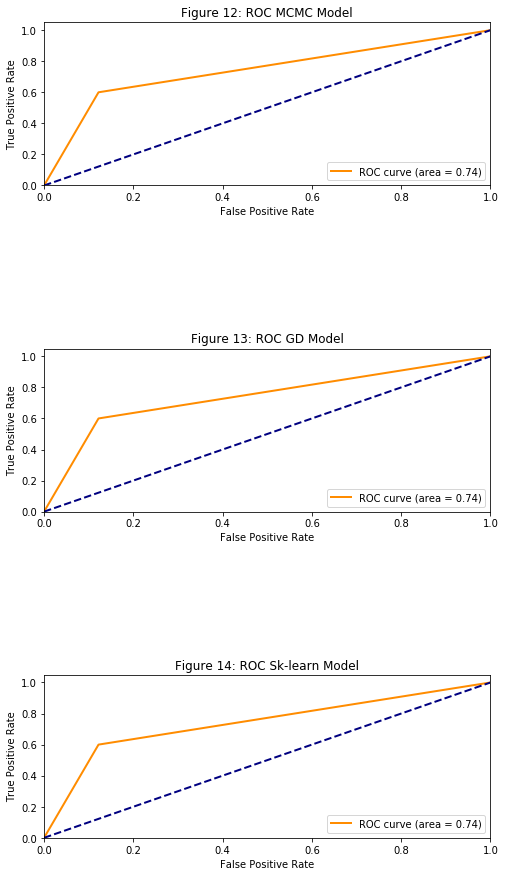

In [174]:
f, ax = plt.subplots(figsize=(8, 15))
plt.subplot(311)
ROC(clf_hc.predict(hc[1].values),hc[3],"Figure 12: ROC MCMC Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(312)
ROC(clf2_hc.predict(hc[1]),hc[3],"Figure 13: ROC GD Model")
plt.subplots_adjust(hspace = 1)
plt.subplot(313)
ROC(sk_clf_hc.predict(hc[1]),hc[3],"Figure 14: ROC Sk-learn Model")